## PbSO4 tutorial: indexing, spacegroup determination & structure solution
In this notebook, you can:
* Load the powder diffraction data and create the PowderPattern object, for two diffrection patterns (X-ray and neutron)
* Find the diffraction peaks and index them (determine the unit cell)
* Perform a profile fit to optimise the background and reflection profiles
* Determine the spacegroup
* Add a molecule to describe the contents of the Crystal structure
* Solve the Crystal structure using a Monte-Carlo/Parallel tempering algorithm, using both X-ray and neutron diffraction patterns
* Save the best result to a CIF file and to Fox .xmlgz format

Notes:
* This is a simple case, which illustrates the possibility of joint X-ray/neutron optimisation.
* It is important to follow the steps relatively linearly and avoid going back to previous cells until you know better. For example to avoid adding multiple times Scatterer/Molecule objects in the crystal structure, or multiple crystalline phases to the powder pattern with the same crystal, etc...

### Imports

In [1]:
# 'widget' allows live update and works in both classical notebooks and jupyter-lab.
# Otherwise 'notebook', 'ipympl', 'inline' can be used
%matplotlib widget

import os
import pyobjcryst
import numpy as np
import matplotlib.pyplot as plt
from pyobjcryst.crystal import *
from pyobjcryst.scatteringpower import ScatteringPowerAtom
from pyobjcryst.atom import Atom
from pyobjcryst.polyhedron import MakeTetrahedron
from pyobjcryst.powderpattern import *
from pyobjcryst.radiation import RadiationType
from pyobjcryst.indexing import *
from pyobjcryst.molecule import *
from pyobjcryst.globaloptim import MonteCarlo
from pyobjcryst.io import xml_cryst_file_save_global

### Create powder pattern object, download data if necessary
We start with the X-ray data which will be used to determine the unit cell and spacegroup.

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Radiation: X-Ray,Wavelength= tube: Cu, Alpha1/Alpha2= 0.5Imported powder pattern: 6001 points, 2theta= 10.000 -> 160.000, step= 0.025



100 48688  100 48688    0     0   100k      0 --:--:-- --:--:-- --:--:--  100k


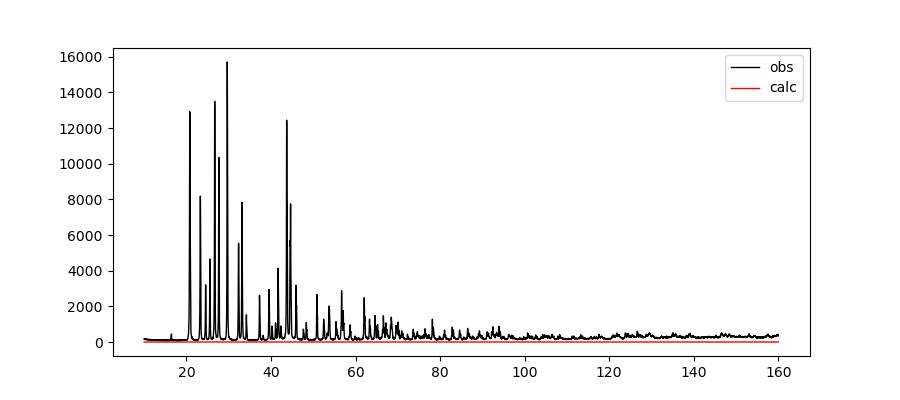

In [2]:
px = PowderPattern()
if not os.path.exists("pbso4-x.dat"):
    os.system("curl -o pbso4-x.dat https://raw.githubusercontent.com/vincefn/objcryst/master/Fox/example/tutorial-pbso4/xray.dat")
px.ImportPowderPatternFullprof("pbso4-x.dat")
px.SetWavelength("Cu")  # Valid strings for X-ray tubes are "Cu", "CuA1",...
print(px.GetRadiation()) # Better check the string was understood
px.plot()

### Find peaks & index the reflections
In this case the peaks are automatically found without any parasitic phase.

And the unit cell is also indexed without any ambiguity. This uses the dichotomy in volume approach (Louër & Boultif).

... It is not always that easy !

In [3]:
# Index
pl = px.FindPeaks(1.5, -1, 1000)
if len(pl) > 20:
    pl.resize(20)  # Only keep 20 peaks
for peak in pl:
    print(peak)

ex = quick_index(pl)

print("Solutions:")
for s in ex.GetSolutions():
    print(s)

Peak dobs=0.23410+/-0.00049 iobs=5.631088e+04 (? ? ?))
Peak dobs=0.26180+/-0.00049 iobs=3.661422e+04 (? ? ?))
Peak dobs=0.27573+/-0.00048 iobs=1.369719e+04 (? ? ?))
Peak dobs=0.28690+/-0.00041 iobs=2.120413e+04 (? ? ?))
Peak dobs=0.29939+/-0.00048 iobs=5.965503e+04 (? ? ?))
Peak dobs=0.31016+/-0.00048 iobs=4.475041e+04 (? ? ?))
Peak dobs=0.33210+/-0.00048 iobs=6.886522e+04 (? ? ?))
Peak dobs=0.36110+/-0.00048 iobs=2.483898e+04 (? ? ?))
Peak dobs=0.36997+/-0.00047 iobs=3.424055e+04 (? ? ?))
Peak dobs=0.38119+/-0.00047 iobs=6.008678e+03 (? ? ?))
Peak dobs=0.41488+/-0.00047 iobs=1.116247e+04 (? ? ?))
Peak dobs=0.43867+/-0.00047 iobs=1.291596e+04 (? ? ?))
Peak dobs=0.44637+/-0.00047 iobs=3.054905e+03 (? ? ?))
Peak dobs=0.45514+/-0.00046 iobs=3.965780e+03 (? ? ?))
Peak dobs=0.46161+/-0.00046 iobs=1.755345e+04 (? ? ?))
Peak dobs=0.46832+/-0.00046 iobs=3.017849e+03 (? ? ?))
Peak dobs=0.48313+/-0.00053 iobs=5.114404e+04 (? ? ?))
Peak dobs=0.49213+/-0.00052 iobs=3.115425e+04 (? ? ?))
Peak dobs=

### Create a crystal phase using the indexed unit cell

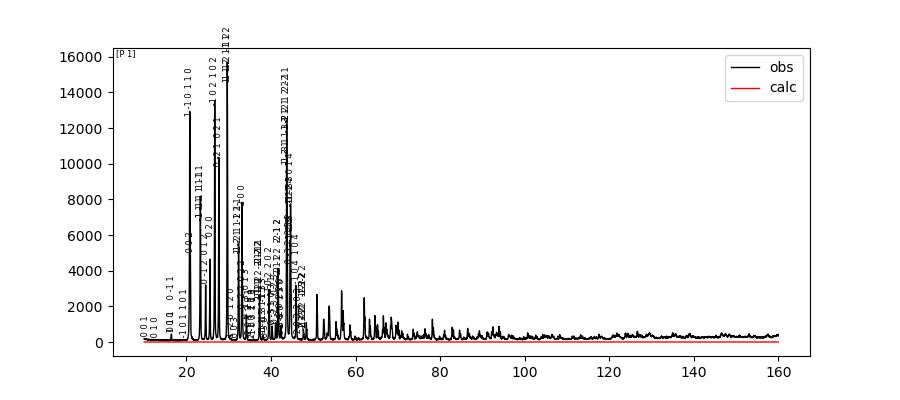

In [4]:
uc = ex.GetSolutions()[0][0].DirectUnitCell()
c = pyobjcryst.crystal.Crystal(uc[0], uc[1], uc[2], uc[3], uc[4], uc[5], "P1")
pdiff = px.AddPowderPatternDiffraction(c)

# Plot with indexing in new figure
px.plot(diff=False,fig=None,hkl=True)

### Fit the profile and background
We use a maximum sin(theta)/lambda because we don't really need high angle/high resolution data.

This will go faster and is more reliable for spacegroup indexing and structure solution.

No background, adding one automatically
Selected PowderPatternDiffraction:    with Crystal:  
Profile fitting finished.
Remember to use SetExtractionMode(False) on the PowderPatternDiffraction object
to disable profile fitting and optimise the structure.
Fit result: Rw=  8.06% Chi2=   7704.09  GoF=    1.28  LLK=  1194.686


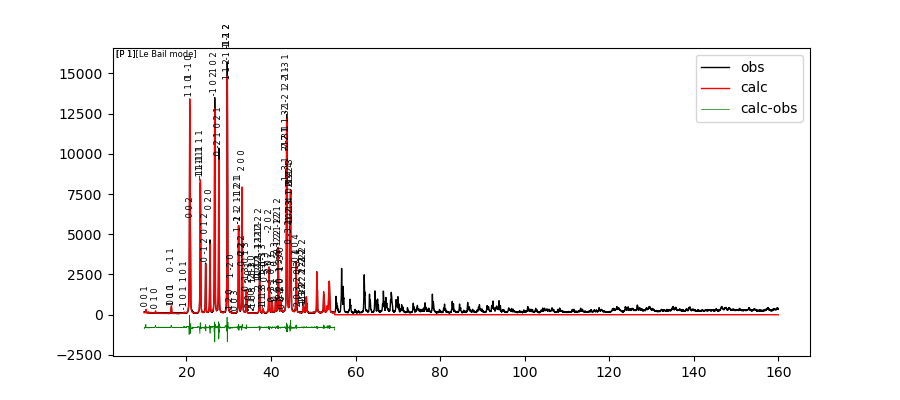

In [5]:
px.SetMaxSinThetaOvLambda(0.3)
px.quick_fit_profile(auto_background=True,plot=False, init_profile=True,verbose=True)
px.quick_fit_profile(plot=False, init_profile=False, asym=True, displ_transl=True, verbose=False)

# Plot in new figure
px.plot(diff=True, fig=None, hkl=True)
print("Fit result: Rw=%6.2f%% Chi2=%10.2f  GoF=%8.2f  LLK=%10.3f" %
      (px.rw * 100, px.chi2, px.chi2/px.GetNbPointUsed(), px.llk))

### Find the spacegroup
The SpaceGroupExplorer can be used to find the optimal spacegroup. 

What `RunAll()` does is try all spacegroups and settings which are compatible with the unit cell (in this case all monoclinic and triclinic), and perform a profile fit (Le Bail only, we don't refine profile parameters or background since these parameters should be OK).

From this several values are extracted for each spacegroup setting:
* **Rw** - the standard full-profile weighted R factor $R_{wp}$
* **GoF**: the chi2 (full profile  $\chi^2=\Sigma\frac{(obs-calc)^2}{\sigma^2}$) divided by the number of points used
* **nGoF**: this is the Goodness-of-Fit, but computed on integration intervals defined by P1 reflections, and then multipled by the number of reflections used divided by the number of reflections for the P1 spacegroup. This is more discriminating and allows to put forward spacegroups which yield a good fit with more extinctions.
* **reflections** is the number of reflections actually taken into account for this spacegroup up to the maximum sin(theta)/lambda
* **extinct446** gives the number of extinct reflections for 0<=H<=4 0<=K<=4 0<=L<=6 (which is used internally as a unique fingerprint for the extinctions)

Some C++ verbose output does not appear here but will be in the jupyter server log if you see it.

The results are sorting by ascending **nGOF**

Unfortunately in this case the correct spacegroup (Pcmn, or Pnma if the axis were exchanged) is only one among possible choices (P21cn has the same extinctions), so we'll select it but in a real case, the different possible spacegroups would need to be tested.

Beginning spacegroup exploration... 348 to go...
  (#  1) P 1           : Rwp=  9.99%  GoF=     6.74  nGoF=     1.81  (158 reflections,   0 extinct)
  (#  2) P -1          : Rwp=  9.99%  GoF=     6.74  nGoF=     1.81  (158 reflections,   0 extinct) [same extinctions as:P 1]
  (#  3) P 1 2 1       : Rwp= 10.36%  GoF=     7.14  nGoF=     1.18  ( 95 reflections,   0 extinct)
  (#  3) P 1 1 2       : Rwp= 10.21%  GoF=     6.93  nGoF=     1.11  ( 93 reflections,   0 extinct)
  (#  3) P 2 1 1       : Rwp= 10.49%  GoF=     7.30  nGoF=     1.26  ( 98 reflections,   0 extinct)
  (#  4) P 1 21 1      : Rwp= 10.56%  GoF=     7.40  nGoF=     1.16  ( 93 reflections,   2 extinct)
  (#  4) P 1 1 21      : Rwp= 10.26%  GoF=     6.99  nGoF=     1.18  ( 90 reflections,   3 extinct)
  (#  4) P 21 1 1      : Rwp= 10.44%  GoF=     7.22  nGoF=     1.21  ( 96 reflections,   2 extinct)
  (#  5) C 1 2 1       : Rwp= 67.10%  GoF=   302.47  nGoF=    75.71  ( 47 reflections,  84 extinct)
  (#  5) A 1 2 1       : 

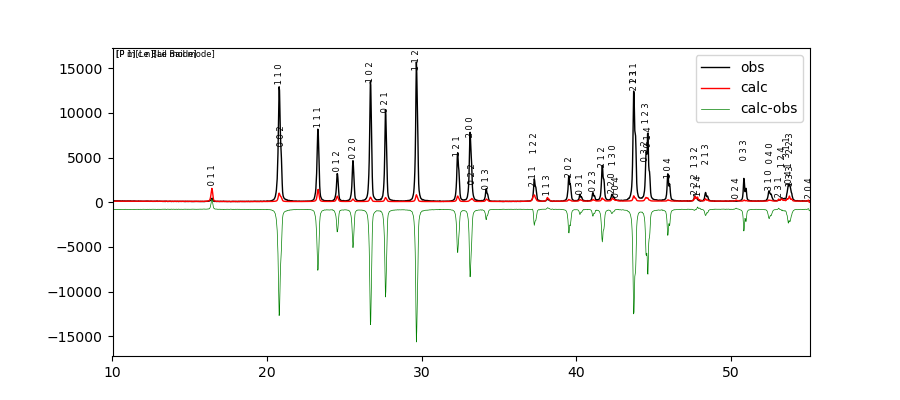

In [6]:
#px.SetMaxSinThetaOvLambda(0.3)  # This can be used to change the number of used reflections
spgex = SpaceGroupExplorer(pdiff)

# NB:verbose C++ output does not appear in a notebook
spgex.RunAll(keep_best=True, update_display=False, fitprofile_p1=False)

for sol in spgex.GetScores():
    #if sol.nGoF > 4 * spgex.GetScores()[0].nGoF:
    if sol.GoF <= 2 * spgex.GetScores()[0].GoF:
        print(sol)

c.GetSpaceGroup().ChangeSpaceGroup("Pmcn")
print("Chosen spacegroup (smallest nGoF): ", c.GetSpaceGroup())

# Updated plot with optimal spacegroup
px.plot(diff=True, fig=None, hkl=True, reset=True)

### Add SO4 and Pb to the crystal structure
First create the atomic scattering powers, then 

In [7]:
pb = ScatteringPowerAtom("Pb", "Pb", 1.0)
s = ScatteringPowerAtom("S", "S", 1.5)
o = ScatteringPowerAtom("O", "O", 2.0)

# When manually creating atomic scattering power, they must be added
# to the Crystal. This is done automatically when importing a Molecule.
c.AddScatteringPower(pb)
c.AddScatteringPower(s)
c.AddScatteringPower(o)

c.AddScatterer(Atom(0.25,0.25,0.25,"Pb", pb))
c.AddScatterer(MakeTetrahedron(c,"SO4",s,o,1.5))

# Let's see what is the resulting crystal contents
print(c)

UnitCell : (P m c n)
    Cell dimensions :  5.39801   6.95849   8.47876  90.00000  90.00000  90.00000
List of scattering components (atoms): 6
Pb               at :  0.2500 0.2500 0.2500, Occup=1.0000 * 0.5000, ScattPow:Pb              , Biso=    1.0000
S                at : -0.0000 0.0000-0.0000, Occup=1.0000 * 0.5000, ScattPow:S               , Biso=    1.5000
O1               at : -0.0000 0.0000 0.1769, Occup=1.0000 * 1.0000, ScattPow:O               , Biso=    2.0000
O2               at : -0.0000 0.2033-0.0589, Occup=1.0000 * 1.0000, ScattPow:O               , Biso=    2.0000
O3               at :  0.2270-0.1017-0.0589, Occup=1.0000 * 0.5000, ScattPow:O               , Biso=    2.0000
O4               at : -0.2270-0.1017-0.0589, Occup=1.0000 * 0.5000, ScattPow:O               , Biso=    2.0000

Occupancy = occ * dyn, where:
        - occ is the 'real' occupancy
        - dyn is the dynamical occupancy correction, indicating  either
          an atom on a special position, or severa

### Create the neutron powder diffraction data and fit the profile
The same steps as for the X-ray data are performed.

However the peak width is larger so that must be fixed to start

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 17902  100 17902    0     0  45463      0 --:--:-- --:--:-- --:--:-- 45552


Imported powder pattern: 2920 points, 2theta= 10.000 -> 155.950, step= 0.050
No background, adding one automatically
Selected PowderPatternDiffraction:    with Crystal:  
Profile fitting finished.
Remember to use SetExtractionMode(False) on the PowderPatternDiffraction object
to disable profile fitting and optimise the structure.
Fit result: Rw=  4.51% Chi2=    874.61  GoF=    0.30  LLK=   219.850


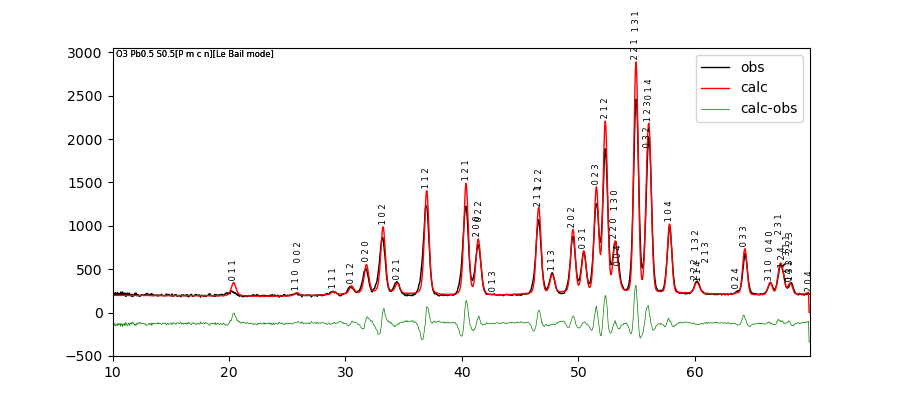

In [8]:
pn = PowderPattern()
if not os.path.exists("pbso4-n.dat"):
    os.system("curl -o pbso4-n.dat https://raw.githubusercontent.com/vincefn/objcryst/master/Fox/example/tutorial-pbso4/neutron.dat")
pn.ImportPowderPatternFullprof("pbso4-n.dat")
pn.GetRadiation().SetRadiationType(RadiationType.RAD_NEUTRON)
pn.SetWavelength(1.909)
pn.SetMaxSinThetaOvLambda(0.3)
pdiffn = pn.AddPowderPatternDiffraction(c)

#
pdiffn.GetProfile().GetPar("W").SetValue(0.001)


pn.FitScaleFactorForIntegratedRw()

# Plot
pn.plot(diff=True, fig=None, hkl=True)

# Fit profile - we keep the unit cell fixed as it was already refined
pn.quick_fit_profile(auto_background=True,plot=True, init_profile=True, cell=False, verbose=True)
pn.quick_fit_profile(plot=False, init_profile=False, cell=False, asym=True, displ_transl=True,
                     backgd=False, verbose=False)

print("Fit result: Rw=%6.2f%% Chi2=%10.2f  GoF=%8.2f  LLK=%10.3f" %
      (pn.rw * 100, pn.chi2, pn.chi2/pn.GetNbPointUsed(), pn.llk))

### Create a MonteCarlo object and add objects (crystal, powder patterns) for optimisation

In [9]:
mc = MonteCarlo()
mc.AddRefinableObj(c)
mc.AddRefinableObj(px)
mc.AddRefinableObj(pn)

### Disable profile fitting before Monte-Carlo
..or else the crystal structure will not be optimised

Note that the following display will be live-updated during the optimisation done below (the last plot is always updated).

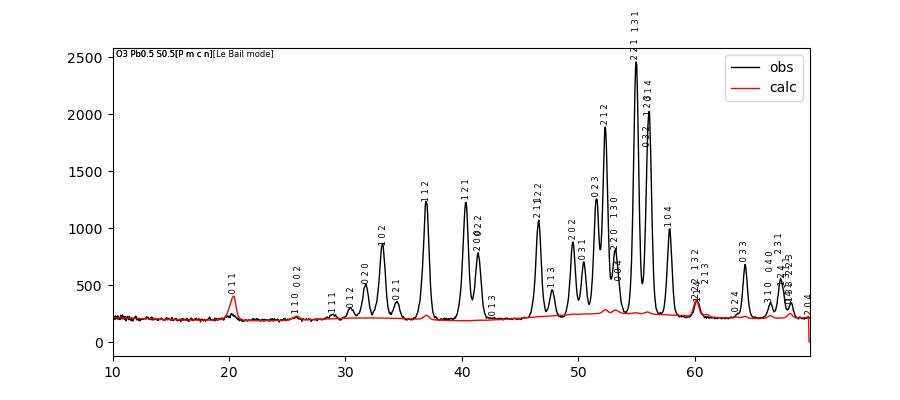

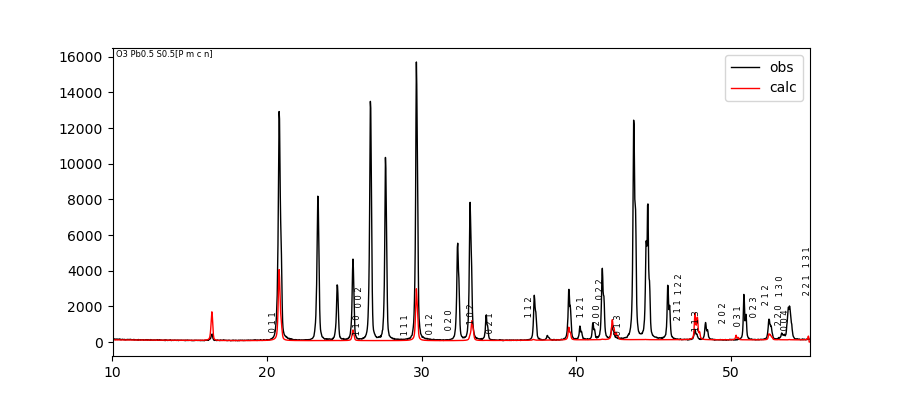

In [10]:
pdiff.SetExtractionMode(False)
pdiffn.SetExtractionMode(False)

px.FitScaleFactorForRw()
pn.FitScaleFactorForRw()

pn.plot(fig=None,diff=False,hkl=True)
px.plot(fig=None,diff=False,hkl=True)

### Display the 3D crystal structure
*Note: this requires installing `ipywidgets` and `py3Dmol` (as of 2021/05 the conda-forge version is obsolete, so just install using pip). Otherwise You will just get a warning message*

This will be updated live during the optimisation, and also when using `RestoreParamSet()` to restore some specific solutions (and generally everytime the underlying Crystal's `UpdateDisplay()` function is called). Just scroll back to see what is being done in the widget.

The `display()` is only really necessary to make sure the widget appears in the notebook. In fact if `c.widget_3d()` is the *last* command in the notebook cell, the display is done automatically. See the ipywidgets documentation if you want to understand this in more details.

Note that bonds may disappear during optimisation, because they are automatically assigned by the javascript viewer, which is quite strict about allowed distances. In the final solution some bonds in the middle of the chain are often missing, though you can see the atoms are reasonably close. But rest assured that any bond defined in the object still exists as defined in pyobjcryst !

In [11]:
display(c.widget_3d())

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Box(children=(VBox(children=(HBox(children=(VBox(children=(FloatRangeSlider(value=(0.0, 1.0), description='Xra…

### Run multiple optimisations
We also enable the automatic least squares every 150k trials, which allows a better convergence

We perform 3 runs, each of 1 million trials using parallel tempering, with default parameters (which should be adequate for all problems). Normally for this structure it would be better to use 2 millions trials so that the correct solution is found during almost every run.

Each run starts from a randomised configuration.

In [12]:
mc.GetOption("Automatic Least Squares Refinement").SetChoice(2)
print("LSQ option: ", mc.GetOption("Automatic Least Squares Refinement").GetChoiceName(2))

# 3D structure view which will be live-updated with the best
# configuration of the current run
display(c.widget_3d())

# Small widget to see the progress of the optimisation, with the current run
# best log-likelihood, the run number and remaining number of trials.
display(mc.widget())

# The powder pattern plot a few cells above should also be updated for each run best solution
mc.MultiRunOptimize(nb_run=3, nb_step=1e5)
print("Final LLK: %.2f" % mc.GetLogLikelihood())

LSQ option:  Every 150000 trials, and at the end of each run


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Box(children=(VBox(children=(HBox(children=(VBox(children=(FloatRangeSlider(value=(0.0, 1.0), description='Xra…

Box(children=(HBox(children=(Label(value='MonteCarlo:', layout=Layout(max_width='25%', width='11em')), Text(va…

Final LLK: 2968.07


### List solutions
All solutions are stored in a "Parameter Set" which can be restored (assuming that the objects - crystal structure and powder pattern are not altered e.g. by changing the list of atoms, the profile, or the fixed parameters etc...).

This will only record changes of parameters such as atom coordinates, but will not record other changes such as a different spacegroup, or a change of the Scatterers (number of atoms or molecules) inside a Crystal. It can only be used to browse results obtained at the end of `MultiRunOptimize()`.

At the end of the optimisation the best solution is automatically restored.

In [13]:
for i in range(mc.GetNbParamSet()):
    idx = mc.GetParamSetIndex(i)
    cost = mc.GetParamSetCost(i)
    name = mc.GetFullRefinableObj().GetParamSetName(idx)
    print("%3d: LLK=%10.2f, name=%s"%(idx, cost, name))

  0: LLK=   3778.00, name=Best Configuration
  1: LLK=   3839.00, name=Run #3
  2: LLK=   3827.00, name=Run #2
  3: LLK=   3776.00, name=Run #1


### Restore a chosen solution (set of parameters)
Restoring a solution will also update the 3D crystal view above.

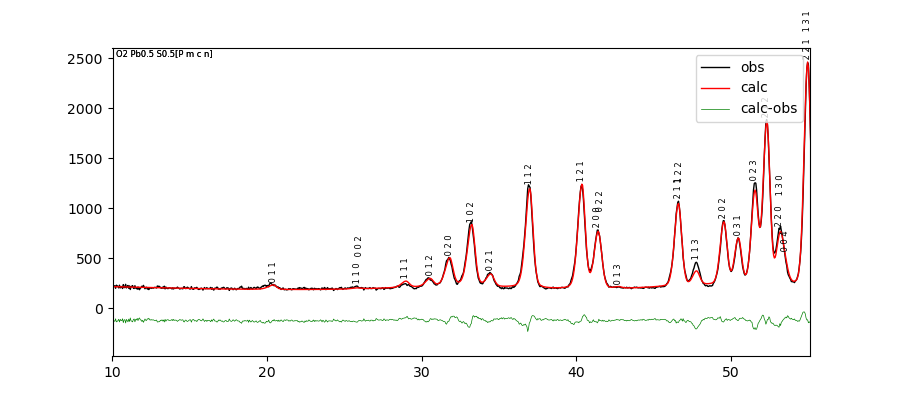

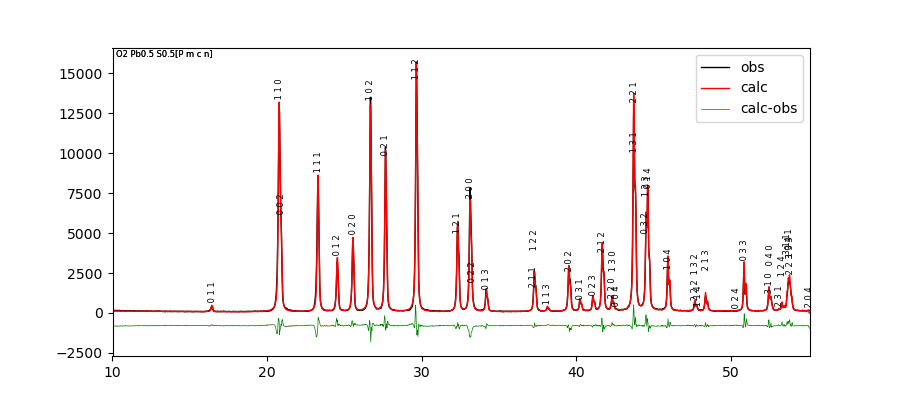

In [14]:
pn.plot(fig=None, diff=True)
px.plot(fig=None, diff=True)
mc.RestoreParamSet(3, update_display=True)

### Save results to CIF and Fox (.xmlgz) formats

In [15]:
# Save result so it can be opened by Fox
xml_cryst_file_save_global('result-pbso4.xmlgz')
# Also export to the CIF format
c.CIFOutput("result-pbso4.cif")